### Importing Necessary Packages

In [1]:
import pandas as pd
import numpy as np
from transformers import pipeline,AutoTokenizer,AutoModelForSequenceClassification,TrainingArguments, Trainer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch
from wordcloud import WordCloud, STOPWORDS
import warnings
from sklearn.metrics import classification_report
from datasets import Dataset,load_dataset
import re

/data/ai-vision/miniconda3/envs/ilgin/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-22 21:31:13.569789: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-22 21:31:13.583670: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747938673.601217 1822473 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747938673.606402 1822473 cuda_blas.c

### Upload dataset

In [2]:
# Original Dataset review
original_df_train = pd.read_csv('./IMDB_Dataset.csv')


In [3]:
original_df_train


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


### Data Preprocessing Step

In [4]:
# The first line has been made into a heading for readability.
original_df_train.rename(columns={'review': 'text', 'sentiment': 'label'}, inplace=True)


In [5]:
original_df_train

,text,label
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [6]:
original_df_train['label'] = original_df_train['label'].map({"positive": 0, "negative": 1})


In [7]:
original_df_train

,text,label
0,One of the other reviewers has mentioned that ...,0
1,A wonderful little production. <br /><br />The...,0
2,I thought this was a wonderful way to spend ti...,0
3,Basically there's a family where a little boy ...,1
4,"Petter Mattei's ""Love in the Time of Money"" is...",0
...,...,...
49995,I thought this movie did a down right good job...,0
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",1
49997,I am a Catholic taught in parochial elementary...,1
49998,I'm going to have to disagree with the previou...,1


In [8]:
import re

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # removing URL
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", text)  # cleaning special character
    text = re.sub(r"\s{2,}", " ", text)  # remove extra space
    return text.strip()

In [9]:
original_df_train['text'] = original_df_train['text'].apply(clean_text)


In [10]:
print(original_df_train.isnull().sum())  # Checking for null value
print(original_df_train.describe())

text     0
label    0
dtype: int64
              label
count  50000.000000
mean       0.500000
std        0.500005
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000


In [11]:
original_df_train['text'].iloc[10]

"Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines br br At first it was very odd and pretty funny but as the movie progressed I didn't find the jokes or oddness funny anymore br br Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest br br I imagine this film would appeal to a stoner who is currently partaking br br For something similar but better try Brother from another planet"

In [12]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(original_df_train["text"],
                                                                      original_df_train["label"],
                                                                      test_size=0.2, random_state=42)


val_texts, test_texts, val_labels, test_labels = train_test_split(test_texts, test_labels, test_size=0.5, random_state=42)


train_df = pd.DataFrame({"text": train_texts, "label": train_labels})
val_df = pd.DataFrame({"text": val_texts, "label": val_labels})
test_df = pd.DataFrame({"text": test_texts, "label": test_labels})

In [13]:
val_df

,text,label
47374,Hollywood has churned out yet another garbage ...,1
48216,A trooper is on the side of the road making su...,1
45929,If you like his show you might be a little dis...,0
48715,A squashy slapstick mess posing as a comedy El...,1
18849,Lucio Fulci was famous for his Italian splatte...,1
...,...,...
49939,Depending entirely on your own personal state ...,1
6420,"Unless you're twelve, this movie really isn't ...",1
48421,I can't tell you all how much I love this movi...,0
26037,The Last Hunt is one of the few westerns ever ...,0


In [14]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
val_dataset = Dataset.from_pandas(val_df)
print(train_dataset)

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 40000
})


### Tokenization and Training

In [15]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [16]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', max_length=512, truncation=True,return_tensors="pt")

# Tokenizing datasets
train_tokenized = train_dataset.map(tokenize_function, batched=True)
test_tokenized = test_dataset.map(tokenize_function, batched=True)
val_tokenized = val_dataset.map(tokenize_function, batched=True)
# Ex: tokenized test format printing
print(test_tokenized)

Map: 100%|██████████| 5000/5000 [00:01<00:00, 4501.33 examples/s]

Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 5000
})


In [17]:
train_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
# Ex: test tokenized with torch formatting
print(train_tokenized.features['label'])

Value(dtype='int64', id=None)


#### Uploading distilbert base uncased model for training

In [18]:

#model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased',torch_dtype=torch.float16, attn_implementation="sdpa" ,num_labels=2)

#import torch

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    torch_dtype=torch.bfloat16,  # FP16 instead of FP32
    attn_implementation="sdpa",  # SDPA instead of "eager"
    num_labels=2
).to("cuda")

#model = torch.compile(model)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus: # so tf does not map all gpu space
	tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
from transformers import Trainer, TrainingArguments

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Epoch evalution strategy instead of steps
    #eval_steps=50,
    learning_rate=2e-6,
    per_device_train_batch_size=16, # 256,512 
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    #weight_decay=0.0001, # 0.01 # decreasing training and eval loss accuracy
    report_to="none",
    bf16=True,
    fp16=False,
    logging_steps=200,
    #gradient_accumulation_steps=4, # simulation of 64 x 4 batch size # 
    save_total_limit=1,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    #fp16_opt_level="O2",
)

# Creating of trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Model Training
trainer.train()

In [ ]:
from sklearn.metrics import accuracy_score

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}

In [ ]:
metrics = trainer.evaluate()
print(metrics)

In [ ]:
print(train_tokenized[0])

In [19]:
#model.save_pretrained("./bert-finetuned-amazon-reviews")
#tokenizer.save_pretrained("./bert-finetuned-amazon-reviews")
trainer.save_model("./bert-finetuned-imdb_v4")
tokenizer.save_pretrained("./bert-finetuned-imdb_v4")

NameError: name 'trainer' is not defined

In [20]:

model_path = "./bert-finetuned-imdb_v4"

# Upload Model
model = AutoModelForSequenceClassification.from_pretrained(model_path).to("cuda")

# Upload Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)



### Calculation of Metrics

In [21]:
from torch.utils.data import DataLoader
from datasets import Dataset
import numpy as np
from tqdm import tqdm
#test_tokenized = test_tokenized.rename_columns({"label": "labels"})
testing_dataloader = DataLoader(test_tokenized, batch_size=128, shuffle=False)

model.eval()
preds = []
labels = []

with torch.no_grad():
    for batch in tqdm(testing_dataloader,desc="Prediction Progress",unit= "batch"):
        inputs = {k:v.to("cuda") for k,v in batch.items() if k != "label"}
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits,dim=-1).cpu().numpy()

        preds.extend(predictions)
        labels.extend(batch["label"].cpu().numpy())

preds = np.array(preds)
labels = np.array(labels)

Prediction Progress: 100%|██████████| 40/40 [00:30<00:00,  1.30batch/s]


Accuracy: 0.9332
Precision: 0.9415
Recall: 0.9216
F1 Score: 0.9314


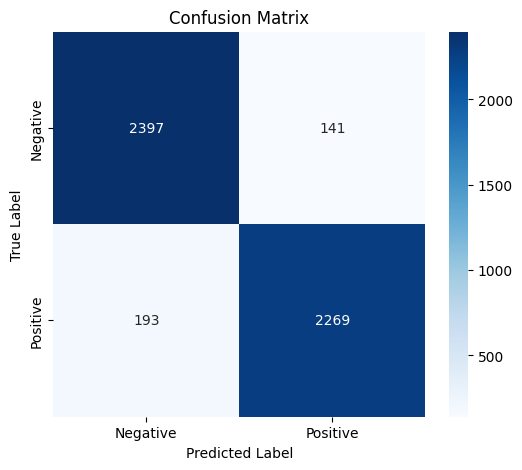

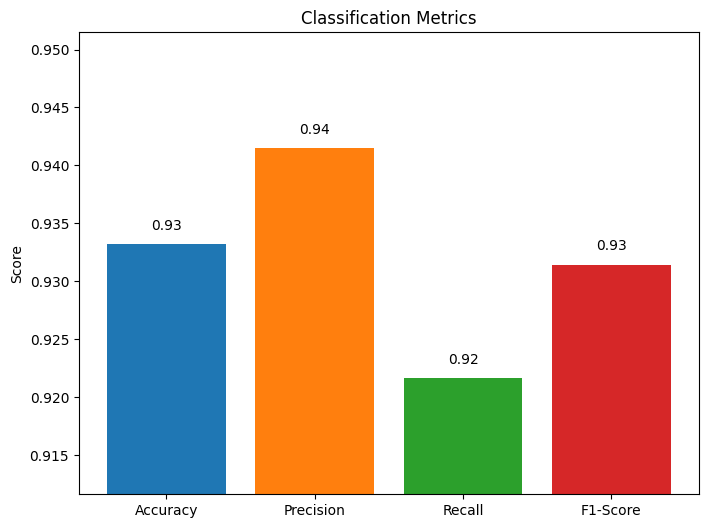

In [23]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
# Accuracy 
accuracy = accuracy_score(labels, preds)

# Precision, Recall, F1-score(average="binary" for 2 class )
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")

# Confusion Matrix 
conf_matrix = confusion_matrix(labels, preds)

# Results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 📌 **Confusion Matrix Visualization**
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 📌 **Precision - Recall - F1 Score Bar Chart**
#metrics = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}
metrics = {
    "Accuracy" : accuracy,
    "Precision": precision,
    "Recall"   : recall,
    "F1-Score" : f1
}

# Dinamik y-ekseni aralığı: en düşük değerin hemen altından en yüksek değerin biraz üstüne
values = list(metrics.values())
min_val, max_val = min(values), max(values)
margin = 0.01  # %5 marjin
ymin = max(min_val - margin, 0)
ymax = min(max_val + margin, 1.0)

# Renk paleti (4 farklı renk)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

plt.figure(figsize=(8,6))
bars = plt.bar(metrics.keys(), metrics.values(), color=colors)
plt.ylim(ymin, ymax)
plt.ylabel("Score")
plt.title("Classification Metrics")

# Her bar'ın tepesine değer ekleyelim
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.001,
        f"{height:.2f}",
        ha="center",
        va="bottom"
    )
plt.show()


### Manuel Testing 

In [24]:
test_sentence = ["I absolutely loved this movie! The performances were brilliant and the story kept me hooked from start to finish."]
inputs = tokenizer(test_sentence, padding=True, truncation=True, return_tensors="pt", max_length=512).to("cuda")
with torch.no_grad():
    output_of_manuel = model(**inputs)

predictions_of_manuel = torch.argmax(output_of_manuel.logits,dim=-1)

for sentence,prediction_of_manuel in zip(test_sentence,predictions_of_manuel):
    sentiment = "Negative" if prediction_of_manuel.item() == 1 else "Positive"
    print(f"Sentence: '{sentence}' => Sentiment: {sentiment}")

Sentence: 'I absolutely loved this movie! The performances were brilliant and the story kept me hooked from start to finish.' => Sentiment: Positive


In [25]:
print(prediction_of_manuel)

tensor(0, device='cuda:0')


In [ ]:
# Cross data validation amazon to imdb model , otherwise.
# bir de hatalı yapanlarda bir bias var mı hata ayıklama,
# görselleştirmeyi düzenlemek gerekiyo, detaylı gözüksün değerler.
# 